# Wrinkle in our analysis: better batters are given more chances to bat, therefore at bats and batting averages are correlated

## To account for this systematic relationship, we can give each player a unique prior

### This method is called *Beta-Binomial Regression*

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20,12]
plt.style.use('fivethirtyeight')

from scipy.stats import beta
from scipy import special
import numpy as np

In [16]:
a, b = 117.98357784382168, 318.54678927619267

In [17]:
df = pd.read_csv('Data\core\Batting.csv')
#getting rid of rows with no at bats
df = df[df['AB']>0]

#filtering out pitchers
list_pitcher_IDs = list(pd.read_csv('Data\core\Pitching.csv')['playerID'].drop_duplicates())

df = df[~df['playerID'].isin(list_pitcher_IDs)]

#adding player names
df_player_names = pd.read_csv('Data\core\Master.csv')[['playerID', 'nameFirst', 'nameLast']].drop_duplicates()

dict_player_names = {df_player_names.iloc[i]['playerID']:
                     str(df_player_names.iloc[i]['nameFirst'])+' '+str(df_player_names.iloc[i]['nameLast']) for i in 
                     range(len(df_player_names))}

#removing blank names
for playerID in dict_player_names.keys():
    if dict_player_names[playerID].split(' ')[0]=='nan':
        dict_player_names[playerID] = dict_player_names[playerID].split(' ')[1]
        
df['Name'] = df['playerID'].map(lambda x: dict_player_names[x])

df_BA = df.groupby(['playerID', 'Name'], as_index=False)[['AB','H']].sum()
df_BA['average'] = 0.000

#working around nan error with pandas divide
for row in df_BA.index:
    H = df_BA.loc[row]['H']
    AB = df_BA.loc[row]['AB']
    val = float(H)/float(AB)
    df_BA = df_BA.set_value(row, 'average', val)
    
df_BA['Empirical Bayes Estimate'] = df_BA.apply(lambda x: (x['H']+a)/(x['AB']+a+b), axis=1)

df_BA['alpha1'] = df_BA['H'] + a
df_BA['beta1'] = df_BA['AB'] - df_BA['H'] + b

### Let's compare the number of at bats to raw batting average

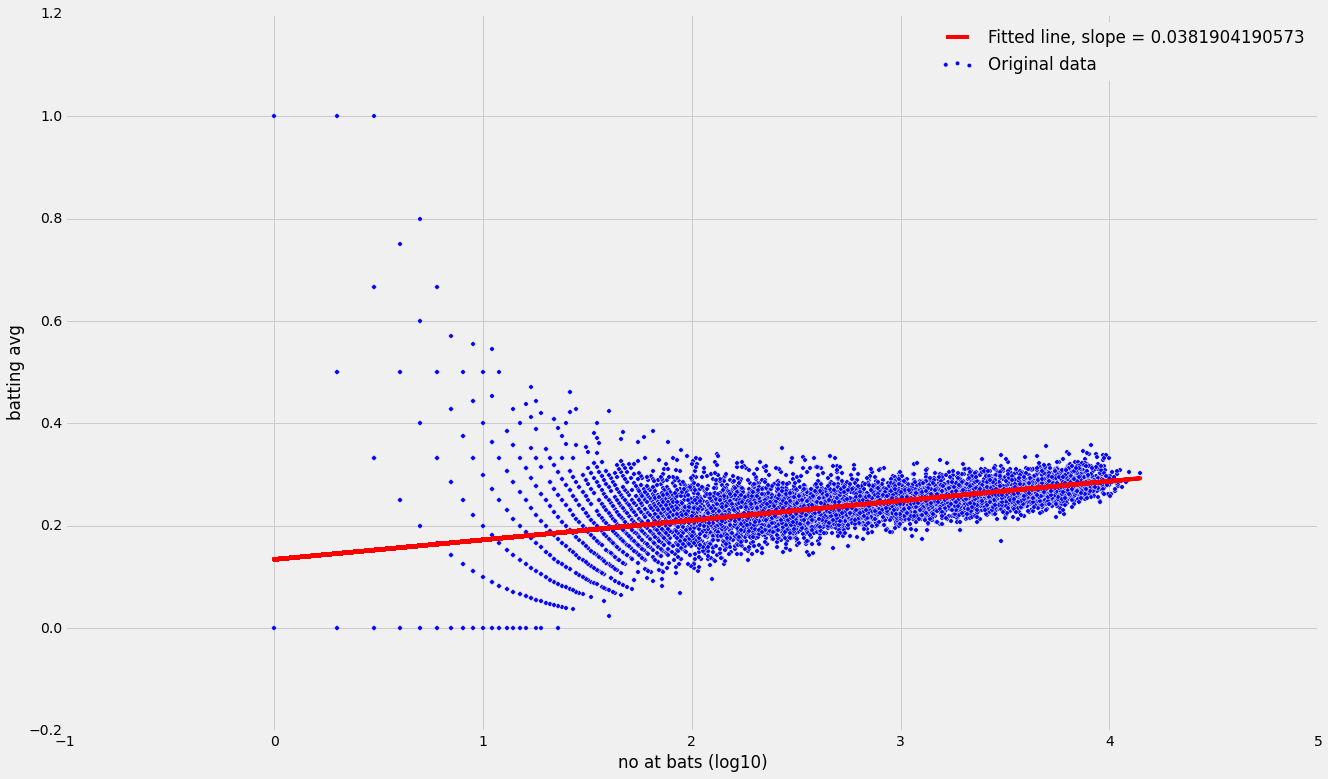

In [28]:
x = np.log10(df_BA.AB.values)
y = df_BA.average.values

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]

plt.scatter(x, y, label = 'Original data')
plt.plot(x, m*x + c, 'r', label='Fitted line, slope = '+str(m))
plt.legend(loc='upper right')
plt.ylabel('batting avg')
plt.xlabel('no at bats (log10)')
plt.show()

# Clearly a positive slope for the regression line

# Facts:
## 1. Players with a high AB value aren't shrunken very much by the empirical bayes estimate (recall: high number of AB wrt $\alpha + \beta$). We can also see from the chart above that they're more likely to be good batters

## 2. Players with a low AB value have their batting average pulled towards the average for the universe of players i.e. their performance history has a low impact on our estimate of their "real" batting average

# Both of these facts increase the estimated "real" batting average of the players therefore WE ARE SYSTEMATICALLY OVERESTIMATING BATTING AVERAGE

____

# As of right now, our model estimates the "real" batting average of a player as:

# $p_{i} \sim \text{Beta}(\alpha_{0}, \beta_{0})$

### Note: we use $p_{i}$ since we're looking at the probability of getting a hit

# So the performance of a player over a series of at bats is estimated as:

# $H_{i} \sim \text{Binomial}(AB_{i}, p_{i})$

# Recall: $\alpha = \frac{\mu}{\sigma}$ and $\beta = \frac{1-\mu}{\sigma}$; so we can rewrite $p_{i}$ as:

# $p_{i}\sim\text{Beta}(\frac{\mu_{0}}{\sigma_{0}}, \frac{1-\mu_{0}}{\sigma_{0}})$

# Since the expected batting average needs to include some consideration of $log(AB)$, we can define $\mu$ as:

# $\mu_{i} = \mu_{0} + \mu_{AB}\cdot log(AB)$

# Now, we can rewrite $\alpha$ and $\beta$ as:

#  $\alpha_{0,i} = \frac{\mu_{i}}{\sigma_{0}} = \frac{\mu_{0} + \mu_{AB}\cdot log(AB)}{\sigma_{0}}$ ; $\beta_{0,i} = \frac{1-\mu_{i}}{\sigma_{0}} = \frac{1-(\mu_{0} + \mu_{AB}\cdot log(AB))}{\sigma_{0}}$

# Then we can finally rewrite $p_{i}$ and $H_{i}$ as:

# $p_{i} \sim \text{Beta}(\alpha_{0,i}, \beta_{0,i})$

# $H_{i} \sim \text{Binomial}(AB_{i}, p_{i})$

# This representation of our model is called *beta-binomial regression*

### We're regressing our beta value against the binomial distribution of $H$